In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import random
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data preparation

In [85]:
df = pd.read_csv('dataset.csv')

In [86]:
print(f'number of duplicate rows: {df.duplicated().sum()}\nnumber of null values:\n{df.isna().sum()}')

number of duplicate rows: 0
number of null values:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [87]:
df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1, inplace = True)

In [88]:
df.shape

(114000, 16)

In [89]:
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [90]:
df.info

<bound method DataFrame.info of         popularity  duration_ms  explicit  danceability  energy  key  \
0               73       230666     False         0.676  0.4610    1   
1               55       149610     False         0.420  0.1660    1   
2               57       210826     False         0.438  0.3590    0   
3               71       201933     False         0.266  0.0596    0   
4               82       198853     False         0.618  0.4430    2   
...            ...          ...       ...           ...     ...  ...   
113995          21       384999     False         0.172  0.2350    5   
113996          22       385000     False         0.174  0.1170    0   
113997          22       271466     False         0.629  0.3290    0   
113998          41       283893     False         0.587  0.5060    7   
113999          22       241826     False         0.526  0.4870    1   

        loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0         -6.746     0

In [91]:
print(f'number of duplicate rows: {df.duplicated().sum()}\nnumber of null values:\n{df.isna().sum()}')

number of duplicate rows: 7093
number of null values:
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


# Preprocessing

In [92]:
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [93]:
df = labelencoder(df)
df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


# Loading and Undersampling

In [94]:
X = df.loc[:,df.columns != 'explicit'].values
y = df['explicit'].values

undersample = NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

print("Contents of y_train: ",Counter(y_train))
print("Contents of y_test: ",Counter(y_test))

Contents of y_train:  Counter({True: 7798, False: 7797})
Contents of y_test:  Counter({False: 1950, True: 1949})


# Declaring Models

In [95]:
dummy = DummyClassifier(random_state=0)
dtc = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
adb = AdaBoostClassifier(random_state=0)
bc = BaggingClassifier(random_state=0)

# Hyperparameter Search

In [104]:
param_rf = {
    'n_estimators' : np.linspace(100,200, dtype='int16'),
}
param_adb = {
    'n_estimators' : np.linspace(100,200, dtype='int16'),
    'learning_rate' : np.linspace(0.0,1.0),
}
param_bc = {
    'n_estimators' : np.linspace(100,200, dtype='int16'),
}

search_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, verbose=2, random_state=0)
search_adb = RandomizedSearchCV(adb, param_adb, n_iter=10, verbose=2, random_state=0)
search_bc = RandomizedSearchCV(bc, param_bc, n_iter=10, verbose=2, random_state=0)

search_rf.fit(X_train, y_train)
search_adb.fit(X_train, y_train)
search_bc.fit(X_train, y_train)

print("Random Forest best parameters: ", search_rf.best_params_)
print("Random Forest average accuracy: ", search_rf.best_score_)
print("AdaBoost best parameters: ", search_adb.best_params_)
print("AdaBoost average accuracy: ", search_adb.best_score_)
print("Bagging best parameters: ", search_bc.best_params_)
print("Bagging average accuracy: ", search_bc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................................n_estimators=157; total time=   4.4s
[CV] END ...................................n_estimators=157; total time=   4.2s
[CV] END ...................................n_estimators=157; total time=   4.3s
[CV] END ...................................n_estimators=157; total time=   4.4s
[CV] END ...................................n_estimators=157; total time=   4.3s
[CV] END ...................................n_estimators=122; total time=   3.5s
[CV] END ...................................n_estimators=122; total time=   3.6s
[CV] END ...................................n_estimators=122; total time=   3.4s
[CV] END ...................................n_estimators=122; total time=   3.5s
[CV] END ...................................n_estimators=122; total time=   3.4s
[CV] END ...................................n_estimators=120; total time=   3.3s
[CV] END ...................................n_es

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................................n_estimators=157; total time=  18.0s
[CV] END ...................................n_estimators=157; total time=  18.3s
[CV] END ...................................n_estimators=157; total time=  18.1s
[CV] END ...................................n_estimators=157; total time=  17.8s
[CV] END ...................................n_estimators=157; total time=  17.7s
[CV] END ...................................n_estimators=122; total time=  13.8s
[CV] END ...................................n_estimators=122; total time=  13.8s
[CV] END ...................................n_estimators=122; total time=  13.9s
[CV] END ...................................n_estimators=122; total time=  13.8s
[CV] END ...................................n_estimators=122; total time=  14.4s
[CV] END ...................................n_estimators=120; total time=  13.9s
[CV] END ...................................n_es

# Declaring Model with New Parameters

In [106]:
dummy = DummyClassifier(random_state=0)
dtc = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0, n_estimators=157)
adb = AdaBoostClassifier(random_state=0, n_estimators=163, learning_rate=0.69387755)
bc = BaggingClassifier(random_state=0, n_estimators=183)

# Fitting and Storing predictions

In [107]:
dummy.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rf.fit(X_train, y_train)
adb.fit(X_train, y_train)
bc.fit(X_train, y_train)

BaggingClassifier(n_estimators=183, random_state=0)

In [108]:
dummypredictions = dummy.predict(X_test)
treepredictions = dtc.predict(X_test)
forestpredictions = rf.predict(X_test)
adapredictions = adb.predict(X_test)
baggingpredictions = bc.predict(X_test)


# Creating and Visualizing Confusion Matrices

In [109]:
confusionMatrices=[confusion_matrix(y_test,dummypredictions).ravel(), confusion_matrix(y_test,treepredictions).ravel(), 
                   confusion_matrix(y_test,forestpredictions).ravel(), confusion_matrix(y_test,adapredictions).ravel(),
                   confusion_matrix(y_test,baggingpredictions).ravel()]

df = pd.DataFrame(confusionMatrices, columns = ['TN', 'FP', 'FN', 'TP'], 
                  index=['Dummy','DecisionTree', 'RandomForest','AdaBoost','Bagging'])

df['Accuracy (%)'] = (df['TP']+df['TN']) /(df['TP']+df['TN']+df['FP']+df['FN'])*100
df['Precision (%)'] = df['TP'] /(df['TP']+df['FP'])*100
df['Recall (%)'] = df['TP'] /(df['TP']+df['FN'])*100


print(df.round(2))


                TN    FP   FN    TP  Accuracy (%)  Precision (%)  Recall (%)
Dummy            0  1950    0  1949         49.99          49.99      100.00
DecisionTree  1539   411  411  1538         78.92          78.91       78.91
RandomForest  1694   256  267  1682         86.59          86.79       86.30
AdaBoost      1574   376  436  1513         79.17          80.10       77.63
Bagging       1692   258  283  1666         86.12          86.59       85.48


# Validating Results of Random Forest

In [110]:
print("training accuracy: %.01f%%" % (rf.score(X_train,y_train)*100))
print("testing accuracy: %.01f%%" % (rf.score(X_test,y_test)*100))

for k in range(2,11):
    scr = cross_val_score(rf,X_train,y_train,cv=k)
    print("accuracy with %d folds: %.1f%%" % (k, scr.mean()*100))

training accuracy: 100.0%
testing accuracy: 86.6%
accuracy with 2 folds: 82.9%
accuracy with 3 folds: 84.1%
accuracy with 4 folds: 84.6%
accuracy with 5 folds: 84.9%
accuracy with 6 folds: 85.1%
accuracy with 7 folds: 85.5%
accuracy with 8 folds: 85.3%
accuracy with 9 folds: 85.4%
accuracy with 10 folds: 85.5%


# Visualizing the Importance of each Feature

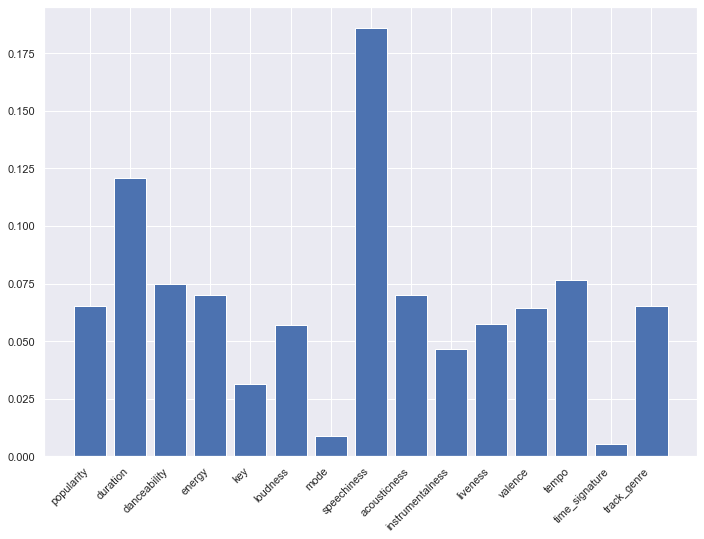

In [118]:
importances = rf.feature_importances_
plt.bar([x for x in range(len(importances))], importances)
bars = ('popularity', 'duration', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness'
       , 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre')
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars, rotation=45, horizontalalignment='right')
plt.show()